# Vowel Detection Neural Network

## Introduction
1. Train a Feedforward Neural Networks to recognize a vowel based on Linear Predictive Coding (LPC) Coefficients (`LPC14`)
2. Dataset Pairs <`LPC14 Coefficients of vowels`, `1 Hot Encoding of Vowels`>
3. Hidden Layer Neural Network is variable to see which architecture best minimizes loss

## Step 0) Import Libraries and Dataset Constants

In [115]:
# PyTorch for feedforward NN architecture library
import torch
import torch.optim as optim

# Science Python library for loading matlab `.mat` files containing training data `ground_truth.mat` and `training_lpc.mat` 
import scipy.io

# Plotting libraries for analyzing the loss and accuracy of the model
import matplotlib.pyplot as plt
import numpy as np

# For pathing
import os

In [114]:
# Training and Ground Truth Datset: Declared at the end of `Create_LPC_Data_Sets.m`
TRAINING_DATASET_PATH = "training_lpc1.mat"
TRAINING_DATASET_KEY = "training_lpc"

GROUND_TRUTH_DATASET_PATH = "ground_truth1.mat"
GROUND_TRUTH_DATASET_KEY = "ground_truth"

SAVE_DATA_PATH = "./training_losses/"

## Step 1) Import Training Data

In [98]:
# Load in Training Data from Matlab .mat file
training_data_with_meta_data = scipy.io.loadmat(TRAINING_DATASET_PATH)

In [99]:
# Note: `training_lpc` is a name we defined in Matlab
training_data = training_data_with_meta_data[TRAINING_DATASET_KEY]

In [100]:
# Load in Training Data from Matlab .mat file
ground_truth_with_meta_data = scipy.io.loadmat(GROUND_TRUTH_DATASET_PATH)

# Note: `training_lpc` is a name we defined in Matlab
ground_truth = ground_truth_with_meta_data[GROUND_TRUTH_DATASET_KEY]

In [101]:
# There are 218 training examples of LPC14
print(training_data.shape) 

(218, 14)


In [102]:
# There are 218 corresponding lables with a One Hot Encoding of length 10
print(ground_truth.shape) 

(218, 10)


## Step 2) Generate Model Architecture
- As we are trying to use different model architecture, we will use a function to encapsulate the model parameters

In [103]:
# Model Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 100000

# Model Architecture
INPUT_SIZE = training_data.shape[1]
OUTPUT_SIZE = ground_truth.shape[1]

### Step 2a) Create Vowel Classifier Architecutre
- Use a function to create the Feedforward NN architecture and its respective Stochastic Gradient Descent optimizer

In [104]:
def create_lpc_vowel_classifier(
    NUM_LPC: int,
    HIDDEN_LAYER_SIZE: int,
    ONE_HOT_ENCODING_SIZE: int,
    LEARNING_RATE: float
) -> tuple[torch.nn.Module, torch.optim.Optimizer]:
    """
    Creates a Feedforward Neural Network and an optimizer to improve the loss of the model.

    ## Parameters
    INPUT_SIZE: int
        Number of inputs to the NN (in our case, the number of LPCs)

    HIDDEN_LAYER_SIZE: int
        Number of inputs from Input to the Hidden Layer (variable for experimentation purposes)

    ONE_HOT_ENCODING_SIZE: int
        The final output layer's dimensions for the One Hot Encoding of the vowel

    LEARNING_RATE: float
        Learning Rate for the Stochastic Gradient Descent Optimizer    

    ## Returns
    model: torch.nn.Module
        feedforward NN with randomized weights and biases whose architecture is based on the function parameters
    optimzer: torch.optim.Optimizer
        Stochastic Gradient Descent object that uses the gradients calculated 
        by a `loss_function` to update the `model`'s weights and biases
    """

    # Step 1) Create the model architecture
    model = torch.nn.Sequential(
        # Layer 1
        torch.nn.Linear(NUM_LPC, HIDDEN_LAYER_SIZE),
        torch.nn.Sigmoid(),

        # Layer 2
        torch.nn.Linear(HIDDEN_LAYER_SIZE, ONE_HOT_ENCODING_SIZE),
        torch.nn.Softmax(dim=1)
    )

    # Step 2) Create the Stochastic Gradient Descent object
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    return model, optimizer

## Step 2B) Train Classifier
- Next we will have a function responsible for the training iterations of the model we create from `create_lpc_vowel_classifier`
- Note: The `loss_function` using Mean Squared Error is universal across all models, the particular `loss instance` which is associated with the model (responsible for calcuating Gradients) is created using the Loss constructor (`loss_function(prediction Tensor, ground truth Tensor)`)

In [105]:
# Use the sum of the Mean Squared Error loss of every sample in the dataset
loss_function = torch.nn.MSELoss(reduction='sum')

In [106]:
def train_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, training_data: list[float], ground_truth: list[int], NUM_EPOCHS: int, clock_rate: int, print_loss_flag: bool = True) -> list[float]:
    # Step 1) Convert the Training Data and Ground Truthof LPC values into a tensor
    training_tensor = torch.tensor(training_data, dtype=torch.float)
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float)

    loss_history = []

    # Step 2) Train Model
    for i in range(NUM_EPOCHS):

        # Step 2a) Forward Propogate all samples of `training_data`
        vowel_prediction = model(training_tensor)

        # Step 2b) Calculate the loss
        loss = loss_function(vowel_prediction, ground_truth_tensor)

        # Step 2c) Calculate the new gradient (note: we need zero_grad() to clear the previous training iterations gradient)
        optimizer.zero_grad()
        loss.backward()

        # Step 2d) Apply the gradient with the learning rate to updated the weighs and biases
        optimizer.step()

        # Step 3) Record loss history

        if print_loss_flag and i % clock_rate == 0:
            loss_history.append(loss.item())
            print(loss.item())

    return loss_history

## Step 3) Analyze Data Visually
1. Use a plot for seeing the loss of the values over time
2. Visualize the prediction of the model using a 2D color plot
3. Overlay the loss values of different trials of training

In [107]:
def plot_all(loss_history: list[float], num_hidden_neurons: int, trial_num: int, unit: int) -> None:
    plt.rcParams['figure.figsize'] = (15, 15)
    fig, axes = plt.subplots(nrows=5, ncols=10)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(NUM_LPC):
        # Title the graph: ex: Loss of 1 hidden Nuerons for Trial A
        title = f"Loss of {num_hidden_neurons} Hidden Neurons for Trial {chr(ord('A') + trial_num)}"

        # Format Titles
        cur_subplot = axes[i//4][i % 4]
        cur_subplot.set_title(title)
        cur_subplot.set_ylabel(f"Loss")
        cur_subplot.set_xlabel(f"1 unit = {unit} iterations")
        cur_subplot.yaxis.grid(True)

        # Format Boxplots for Front vs. Back Vowels
        cur_subplot.boxplot(
            [lpc_front_vowels[:, i], lpc_back_vowels[:, i]],
            labels=["Front Vowels", "Back Vowels"],
            boxprops=dict(facecolor="salmon"),
            notch=True,
            vert=True,
            patch_artist=True,
        )

In [118]:
def save_data(to_save: list[float], file_path: str, file_name: str) -> None:
    # Get the path
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    full_path = os.path.join(file_path, file_name)

    # Write the entire training loss to that file
    with open(full_path, "w") as file:
        for element in to_save:
            file.write(f"{element}\n")

## Step 4) Linking It All Together
- Call the various functions to create, train, and display the model's outputs

In [111]:
# Number of hidden neurons
HIDDEN_LAYER_SIZES = [1, 2, 3, 4, 5]

# Number of trials for testing a single Hidden layer Architecture
NUM_TRIALS = 10

# Record every `Clock_Rate`th sample
CLOCK_RATE = 1000

# Let there be Five 2D planes where the rows represent the trial number and the columns represent the losses recorded
all_loss_histories = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

In [119]:
for num_hidden_neurons in HIDDEN_LAYER_SIZES:
    for trial_num in range(NUM_TRIALS):
        # Step 1) Create Model
        model, optimizer = create_lpc_vowel_classifier(
            NUM_LPC=INPUT_SIZE,
            HIDDEN_LAYER_SIZE=num_hidden_neurons,
            ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
            LEARNING_RATE=LEARNING_RATE
        )

        # Step 2) Train the model
        loss_history = train_model(
            model=model,
            optimizer=optimizer,
            training_data=training_data,
            ground_truth=ground_truth,
            NUM_EPOCHS=NUM_EPOCHS,
            clock_rate=CLOCK_RATE
        )
    
        # Step 3) Record Loss
        save_data(loss_history, SAVE_DATA_PATH, f"{num_hidden_neurons}_Hidden_Neurons_Trial_{chr(ord('A') + trial_num)}")
        all_loss_histories[num_hidden_neurons - 1][trial_num] = loss_history

205.2540740966797
172.32354736328125
170.53660583496094
169.7047882080078
169.1592254638672
168.75473022460938
168.43756103515625
168.18321228027344
167.98483276367188
167.8619384765625
167.8691864013672
167.85464477539062
166.84237670898438
166.1214141845703
164.8236541748047
162.70162963867188
161.49256896972656
159.98416137695312
160.4881591796875
161.8416748046875
180.0675811767578
177.65167236328125
162.5111541748047
163.64671325683594
163.56602478027344
160.0577850341797
163.87852478027344
165.1878204345703
162.0006561279297
170.40103149414062
186.0592041015625
159.0707244873047
159.15118408203125
162.83267211914062
170.40049743652344
159.65733337402344
161.35243225097656
161.71014404296875
174.6184539794922
165.1921844482422
188.04747009277344
163.82681274414062
161.50372314453125
165.33119201660156
161.51332092285156
159.70018005371094
164.6019287109375
160.9829559326172
160.91363525390625
160.69638061523438
160.89646911621094
166.72654724121094
159.324951171875
159.89315795898

FileNotFoundError: [Errno 2] No such file or directory: './training_losses/1_Hidden_Neurons_Trial_A'

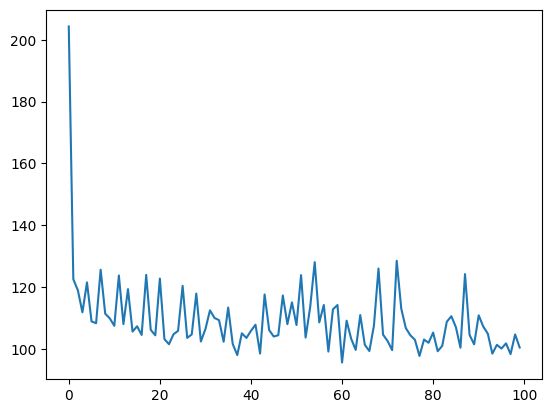

In [ ]:
plt.figure()
plt.title("Loss vs. Epochs")
plt.plot(loss_history)

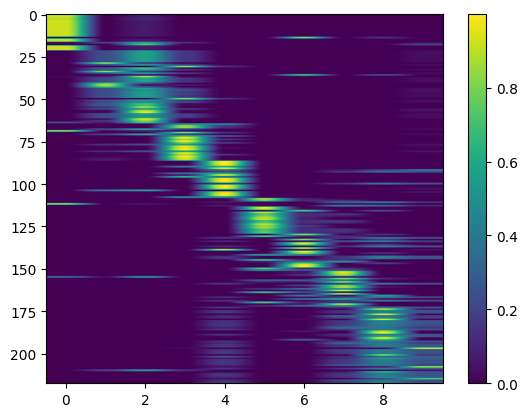

In [ ]:
all_predictions = model(torch.tensor(training_data, dtype=torch.float))
plt.imshow(all_predictions.detach().numpy(), aspect='auto')
plt.colorbar()